[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/baptiste-pasquier/data_2A/blob/main/model_NN.ipynb)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import re
import sklearn
import os
import tensorflow as tf
import tensorflow_hub as hub

# Chargement de la base Sentiment140 préprocessée 

In [2]:
STOP_WORDS = True
LEMMATIZATION = True
file = "train"
if STOP_WORDS:
    file += "_stop"
if LEMMATIZATION:
    file += "_lemm"
df = pd.read_pickle(os.path.join("data", "sentiment140", file+".bz2"))
# df = df.sample(20000, random_state=1234)
df

,sentiment,id,date,query_string,user,text
427065,0,2063663110,Sun Jun 07 03:34:51 PDT 2009,NO_QUERY,BoltClock,
814953,4,1550967208,Sat Apr 18 07:46:22 PDT 2009,NO_QUERY,forpawz,head aspca wag n walk hop weather change good ...
217743,0,1975999939,Sat May 30 16:22:11 PDT 2009,NO_QUERY,amyegsmith,watch night museum well think would pout go sa...
1031560,4,1933074305,Tue May 26 22:55:50 PDT 2009,NO_QUERY,Scharleth,fire light awake im ready
1318246,4,2014351246,Wed Jun 03 01:14:31 PDT 2009,NO_QUERY,twisted77,bought ticket wollongong concert amp go bestie...
...,...,...,...,...,...,...
1277679,4,2001345559,Tue Jun 02 00:35:02 PDT 2009,NO_QUERY,Keri_Keuning,cry exam feel well see brandon bruce
106955,0,1823757283,Sat May 16 22:53:32 PDT 2009,NO_QUERY,KamiThornton,cant go sleep wishing could talk asleep
552273,0,2203360759,Tue Jun 16 23:34:10 PDT 2009,NO_QUERY,aaronstrout,unfortunately get concert late saw great song ...
1328976,4,2015597030,Wed Jun 03 05:04:11 PDT 2009,NO_QUERY,jenny050085,ok report time


In [3]:
df.dtypes

sentiment        int64
id               int64
date            object
query_string    object
user            object
text            object
dtype: object

In [4]:
df['target'] = np.where(df['sentiment']==4, 1, 0)
df = df[['text', 'target']]
df

,text,target
427065,,0
814953,head aspca wag n walk hop weather change good ...,1
217743,watch night museum well think would pout go sa...,0
1031560,fire light awake im ready,1
1318246,bought ticket wollongong concert amp go bestie...,1
...,...,...
1277679,cry exam feel well see brandon bruce,1
106955,cant go sleep wishing could talk asleep,0
552273,unfortunately get concert late saw great song ...,0
1328976,ok report time,1


In [5]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2)

a,b = train_df.copy(), test_df.copy()
X_train, y_train = a['text'], a['target']
X_test, y_test = b['text'], b['target']

train_df, validation_df = train_test_split(train_df, test_size=0.2)
print(len(train_df), 'train examples')
print(len(validation_df), 'validation examples')
print(len(test_df), 'test examples')

32000 train examples
8000 validation examples
10000 test examples


In [6]:
print(len(X_train), 'train examples')
print(len(X_test), 'validation examples')

40000 train examples
10000 validation examples


In [7]:
train_data = tf.data.Dataset.from_tensor_slices((train_df['text'].values, train_df['target'].values))
validation_data = tf.data.Dataset.from_tensor_slices((validation_df['text'].values, validation_df['target'].values))
test_data = tf.data.Dataset.from_tensor_slices((test_df['text'].values, test_df['target'].values))

In [8]:
train_data

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int64)>

In [9]:
for feat, targ in train_data.take(5):
  print ('Features: {}, Target: {}'.format(feat, targ))

Features: b'yoks gon na jus grown one amp stand back n jus smile lame as dont want hahaha u really dont', Target: 1
Features: b'first experience afraid excite ya different', Target: 1
Features: b'fav morganmariah would miniature math nerd', Target: 1
Features: b'truly make sad wrong folk', Target: 0
Features: b'play wii game fam excite get tat tomorrow', Target: 1


In [10]:
train_text_batch, train_target_batch = next(iter(train_data.batch(10)))
train_text_batch

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'yoks gon na jus grown one amp stand back n jus smile lame as dont want hahaha u really dont',
       b'first experience afraid excite ya different',
       b'fav morganmariah would miniature math nerd',
       b'truly make sad wrong folk',
       b'play wii game fam excite get tat tomorrow',
       b'miss sunshine rite usually wake clock last moning wake pm woah',
       b'hot weather incredibly frustrate arghhhh still day though',
       b'special plan weekend xx', b'get depressed day work need change',
       b'ipod'], dtype=object)>

In [11]:
train_target_batch

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([1, 1, 1, 0, 1, 0, 0, 1, 0, 0])>

# TF Hub

In [12]:
MODEL = "nnlm-en-dim128"
VERSION = 2
URL = "https://tfhub.dev/google/"+MODEL+"/"+str(VERSION)
print (URL)

https://tfhub.dev/google/nnlm-en-dim128/2


In [13]:
hub_layer = hub.KerasLayer(URL, input_shape=[], 
                           dtype=tf.string, trainable=True)

In [14]:
hub_layer(train_text_batch[:2])

<tf.Tensor: shape=(2, 128), dtype=float32, numpy=
array([[ 2.00774595e-01,  5.95657937e-02,  1.21114075e-01,
         6.58308044e-02,  3.18486840e-01,  8.50060768e-03,
        -8.45532492e-02, -2.74841279e-01, -9.07452852e-02,
         1.15111180e-01,  1.35088395e-02, -3.21308553e-01,
         1.94872111e-01, -2.32420713e-01,  1.08265787e-01,
        -4.79284786e-02,  4.36205417e-02, -1.87103540e-01,
        -1.36075765e-01, -1.48864836e-01,  4.39990275e-02,
        -2.43422285e-01, -1.82629526e-02, -1.29886821e-01,
         3.16443457e-03, -1.35944173e-01,  1.17020294e-01,
        -9.74209160e-02, -3.91102850e-01, -9.06917080e-02,
         2.62451828e-01,  1.48425519e-01, -5.89482151e-02,
        -5.79260886e-02,  7.92095214e-02,  1.34456947e-01,
         1.05113303e-03, -4.05514054e-02,  1.53410926e-01,
         2.53335506e-01, -1.54415816e-01, -5.74669652e-02,
        -2.42617890e-01, -2.30374485e-01,  4.24316153e-04,
         1.94482103e-01, -4.79566120e-02,  2.37294495e-01,
      

In [15]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               124642688 
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 124,644,769
Trainable params: 124,644,769
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.get_weights()

[array([[ 8.16051960e-01,  3.51142138e-02, -3.23012704e-03, ...,
         -2.68346369e-02, -4.95113060e-02,  1.63635537e-02],
        [ 6.26858950e-01,  1.22697828e-02, -5.47063090e-02, ...,
          7.37033179e-03, -7.09955022e-02, -7.38640875e-02],
        [-1.19781224e-02, -4.65284288e-02, -4.78441420e-04, ...,
          1.27587229e-01,  1.21942766e-01, -3.41316722e-02],
        ...,
        [-1.96687713e-01,  1.08706986e-03, -8.78152475e-02, ...,
          1.77201703e-01, -1.04697749e-01,  4.37770933e-02],
        [-2.06271142e-01, -2.30716169e-02, -7.13550597e-02, ...,
         -3.06905657e-02, -1.14739329e-01, -5.64496219e-02],
        [-1.38024807e-01, -1.27754761e-02, -6.36914894e-02, ...,
          1.03301600e-01,  6.30483963e-04, -4.08159662e-03]], dtype=float32),
 array([[ 0.18430266, -0.04958417,  0.08688459, ...,  0.14648852,
         -0.08967195,  0.0391376 ],
        [-0.07315315, -0.05132382, -0.03326827, ...,  0.12365237,
         -0.06017931, -0.11305254],
        [ 

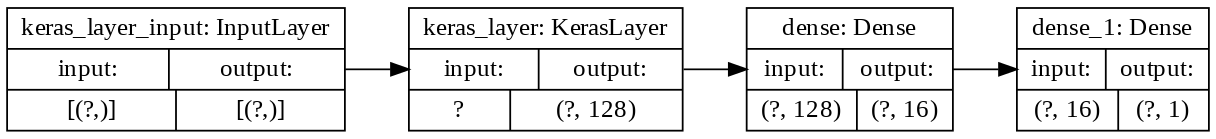

In [17]:
tf.keras.utils.plot_model(model, 
                       #to_file='model.png',
                      show_shapes=True, show_layer_names=True, rankdir='LR', expand_nested=False, dpi=128)

Epoch 1/10
7/7 [==============================] - 1s 95ms/step - loss: 0.6878 - accuracy: 0.5017 - val_loss: 0.6724 - val_accuracy: 0.5017
Epoch 2/10
7/7 [==============================] - 1s 80ms/step - loss: 0.6553 - accuracy: 0.5078 - val_loss: 0.6477 - val_accuracy: 0.5203
Epoch 3/10
7/7 [==============================] - 1s 79ms/step - loss: 0.6216 - accuracy: 0.5452 - val_loss: 0.6199 - val_accuracy: 0.5701
Epoch 4/10
7/7 [==============================] - 1s 80ms/step - loss: 0.5839 - accuracy: 0.6191 - val_loss: 0.5906 - val_accuracy: 0.6364
Epoch 5/10
7/7 [==============================] - 1s 80ms/step - loss: 0.5434 - accuracy: 0.6907 - val_loss: 0.5636 - val_accuracy: 0.6824
Epoch 6/10
7/7 [==============================] - 1s 78ms/step - loss: 0.5033 - accuracy: 0.7376 - val_loss: 0.5424 - val_accuracy: 0.7057
Epoch 7/10
7/7 [==============================] - 1s 78ms/step - loss: 0.4676 - accuracy: 0.7686 - val_loss: 0.5286 - val_accuracy: 0.7151
Epoch 8/10
7/7 [===========

[0.5242826342582703, 0.7336000204086304]

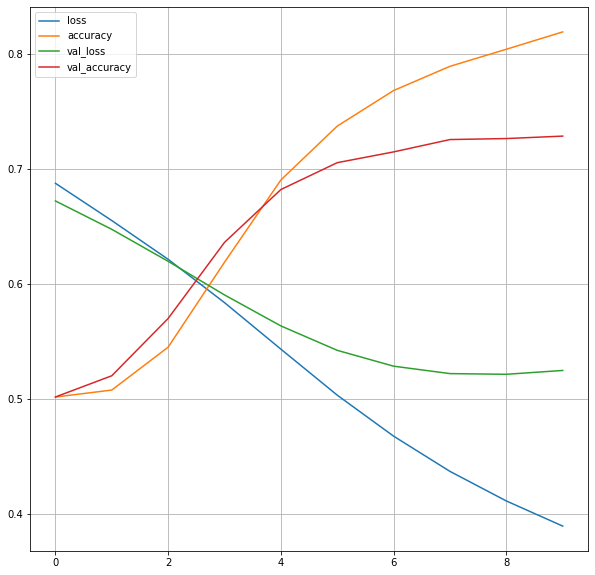

In [18]:
history = model.fit(train_data.shuffle(10000).batch(5000), 
                    epochs=10,
                    validation_data=validation_data.batch(5000),
                    verbose=1)
pd.DataFrame(history.history).plot(figsize=(10,10))
plt.grid(True)
plt.show
model.evaluate(X_test, y_test, verbose=2)

In [19]:
model.get_weights()

[array([[ 8.16051960e-01,  3.51142138e-02, -3.23012704e-03, ...,
         -2.68346369e-02, -4.95113060e-02,  1.63635537e-02],
        [ 6.26858950e-01,  1.22697828e-02, -5.47063090e-02, ...,
          7.37033179e-03, -7.09955022e-02, -7.38640875e-02],
        [-1.19781224e-02, -4.65284288e-02, -4.78441420e-04, ...,
          1.27587229e-01,  1.21942766e-01, -3.41316722e-02],
        ...,
        [-1.79724544e-01, -4.98185353e-03, -8.87180790e-02, ...,
          1.73879921e-01, -1.03553802e-01,  2.70124450e-02],
        [-1.95729375e-01, -4.03746516e-02, -6.92126900e-02, ...,
         -4.46266718e-02, -1.01010114e-01, -5.09248190e-02],
        [-1.16577953e-01, -3.68964709e-02, -7.90690184e-02, ...,
          1.00186519e-01,  7.23644253e-03, -2.35320181e-02]], dtype=float32),
 array([[ 0.18585972,  0.00942799,  0.10804363, ...,  0.21039766,
         -0.02719523,  0.08659147],
        [-0.12228204,  0.02085226, -0.04043368, ...,  0.19217879,
          0.00157551, -0.05993659],
        [ 

In [20]:
def reset_weights(model):
  for layer in model.layers: 
    if isinstance(layer, tf.keras.Model):
      reset_weights(layer)
      continue
    for k, initializer in layer.__dict__.items():
      if "initializer" not in k:
        continue
      # find the corresponding variable
      var = getattr(layer, k.replace("_initializer", ""))
      var.assign(initializer(var.shape, var.dtype))
reset_weights(model)
model.get_weights()

[array([[ 8.16051960e-01,  3.51142138e-02, -3.23012704e-03, ...,
         -2.68346369e-02, -4.95113060e-02,  1.63635537e-02],
        [ 6.26858950e-01,  1.22697828e-02, -5.47063090e-02, ...,
          7.37033179e-03, -7.09955022e-02, -7.38640875e-02],
        [-1.19781224e-02, -4.65284288e-02, -4.78441420e-04, ...,
          1.27587229e-01,  1.21942766e-01, -3.41316722e-02],
        ...,
        [-1.79724544e-01, -4.98185353e-03, -8.87180790e-02, ...,
          1.73879921e-01, -1.03553802e-01,  2.70124450e-02],
        [-1.95729375e-01, -4.03746516e-02, -6.92126900e-02, ...,
         -4.46266718e-02, -1.01010114e-01, -5.09248190e-02],
        [-1.16577953e-01, -3.68964709e-02, -7.90690184e-02, ...,
          1.00186519e-01,  7.23644253e-03, -2.35320181e-02]], dtype=float32),
 array([[ 0.02323119, -0.08935444,  0.16282806, ..., -0.17892906,
         -0.1651815 ,  0.20338762],
        [ 0.09027115, -0.1888125 , -0.04863253, ..., -0.18601269,
         -0.02852762, -0.06121178],
        [ 

Epoch 1/10
32/32 [==============================] - 2s 73ms/step - loss: 0.6112 - accuracy: 0.6028 - val_loss: 0.5505 - val_accuracy: 0.6988
Epoch 2/10
32/32 [==============================] - 2s 74ms/step - loss: 0.4248 - accuracy: 0.8026 - val_loss: 0.5245 - val_accuracy: 0.7268
Epoch 3/10
32/32 [==============================] - 2s 74ms/step - loss: 0.3637 - accuracy: 0.8347 - val_loss: 0.5447 - val_accuracy: 0.7265
Epoch 4/10
32/32 [==============================] - 2s 73ms/step - loss: 0.3317 - accuracy: 0.8534 - val_loss: 0.5724 - val_accuracy: 0.7247
Epoch 5/10
32/32 [==============================] - 2s 73ms/step - loss: 0.3074 - accuracy: 0.8653 - val_loss: 0.5995 - val_accuracy: 0.7155
Epoch 6/10
32/32 [==============================] - 2s 73ms/step - loss: 0.2887 - accuracy: 0.8735 - val_loss: 0.6340 - val_accuracy: 0.7144
Epoch 7/10
32/32 [==============================] - 2s 73ms/step - loss: 0.2731 - accuracy: 0.8807 - val_loss: 0.6663 - val_accuracy: 0.7069
Epoch 8/10
32

[0.7691312432289124, 0.704800009727478]

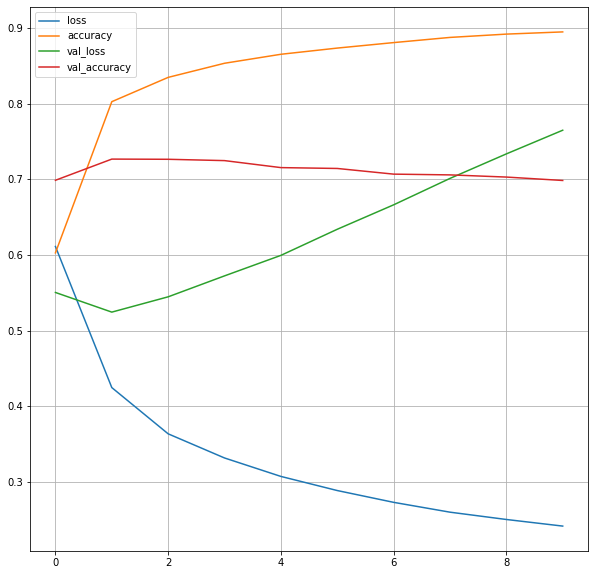

In [21]:
reset_weights(model)
history = model.fit(train_data.shuffle(10000).batch(1000), 
                    epochs=10,
                    validation_data=validation_data.batch(1000),
                    verbose=1)
pd.DataFrame(history.history).plot(figsize=(10,10))
plt.grid(True)
plt.show
model.evaluate(X_test, y_test, verbose=2)

Epoch 1/10
64/64 [==============================] - 5s 72ms/step - loss: 0.4568 - accuracy: 0.7305 - val_loss: 0.5981 - val_accuracy: 0.7096
Epoch 2/10
64/64 [==============================] - 5s 71ms/step - loss: 0.2706 - accuracy: 0.8823 - val_loss: 0.7135 - val_accuracy: 0.7010
Epoch 3/10
64/64 [==============================] - 5s 71ms/step - loss: 0.2508 - accuracy: 0.8901 - val_loss: 0.7818 - val_accuracy: 0.6984
Epoch 4/10
64/64 [==============================] - 5s 72ms/step - loss: 0.2400 - accuracy: 0.8959 - val_loss: 0.8249 - val_accuracy: 0.6951
Epoch 5/10
64/64 [==============================] - 5s 72ms/step - loss: 0.2321 - accuracy: 0.8997 - val_loss: 0.8623 - val_accuracy: 0.6920
Epoch 6/10
64/64 [==============================] - 5s 72ms/step - loss: 0.2264 - accuracy: 0.8995 - val_loss: 0.9000 - val_accuracy: 0.6910
Epoch 7/10
64/64 [==============================] - 5s 71ms/step - loss: 0.2199 - accuracy: 0.9027 - val_loss: 0.9285 - val_accuracy: 0.6865
Epoch 8/10
64

[1.0255801677703857, 0.6909000277519226]

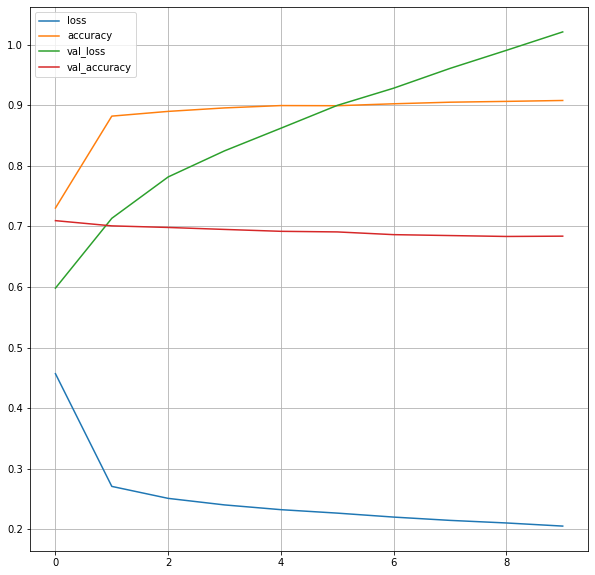

In [22]:
reset_weights(model)
history = model.fit(train_data.shuffle(10000).batch(500), 
                    epochs=10,
                    validation_data=validation_data.batch(500),
                    verbose=1)
pd.DataFrame(history.history).plot(figsize=(10,10))
plt.grid(True)
plt.show
model.evaluate(X_test, y_test, verbose=2)

Epoch 1/10
160/160 [==============================] - 11s 70ms/step - loss: 0.3136 - accuracy: 0.8443 - val_loss: 0.8927 - val_accuracy: 0.6873
Epoch 2/10
160/160 [==============================] - 11s 70ms/step - loss: 0.2325 - accuracy: 0.8935 - val_loss: 0.9475 - val_accuracy: 0.6854
Epoch 3/10
160/160 [==============================] - 11s 70ms/step - loss: 0.2183 - accuracy: 0.9005 - val_loss: 1.0085 - val_accuracy: 0.6826
Epoch 4/10
160/160 [==============================] - 11s 70ms/step - loss: 0.2085 - accuracy: 0.9031 - val_loss: 1.0517 - val_accuracy: 0.6802
Epoch 5/10
160/160 [==============================] - 11s 70ms/step - loss: 0.2009 - accuracy: 0.9059 - val_loss: 1.1144 - val_accuracy: 0.6851
Epoch 6/10
160/160 [==============================] - 11s 70ms/step - loss: 0.1924 - accuracy: 0.9087 - val_loss: 1.1637 - val_accuracy: 0.6794
Epoch 7/10
160/160 [==============================] - 11s 70ms/step - loss: 0.1852 - accuracy: 0.9117 - val_loss: 1.2185 - val_accuracy:

[1.4010518789291382, 0.6794000267982483]

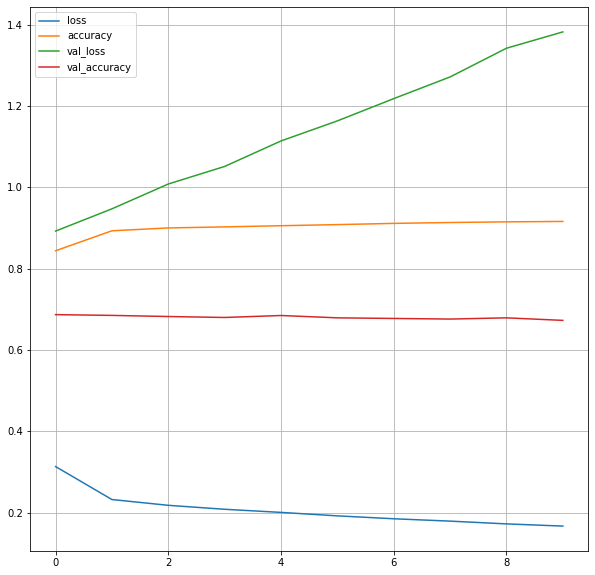

In [23]:
reset_weights(model)
history = model.fit(train_data.shuffle(10000).batch(200), 
                    epochs=10,
                    validation_data=validation_data.batch(200),
                    verbose=1)
pd.DataFrame(history.history).plot(figsize=(10,10))
plt.grid(True)
plt.show
model.evaluate(X_test, y_test, verbose=2)

Epoch 1/10
7/7 [==============================] - 1s 82ms/step - loss: 0.6642 - accuracy: 0.5017 - val_loss: 0.6337 - val_accuracy: 0.4996
Epoch 2/10
7/7 [==============================] - 1s 82ms/step - loss: 0.5751 - accuracy: 0.5070 - val_loss: 0.5644 - val_accuracy: 0.5301
Epoch 3/10
7/7 [==============================] - 1s 82ms/step - loss: 0.4844 - accuracy: 0.6127 - val_loss: 0.5051 - val_accuracy: 0.6640
Epoch 4/10
7/7 [==============================] - 1s 84ms/step - loss: 0.4053 - accuracy: 0.7687 - val_loss: 0.4604 - val_accuracy: 0.7476
Epoch 5/10
7/7 [==============================] - 1s 84ms/step - loss: 0.3427 - accuracy: 0.8436 - val_loss: 0.4306 - val_accuracy: 0.7855
Epoch 6/10
7/7 [==============================] - 1s 86ms/step - loss: 0.2973 - accuracy: 0.8801 - val_loss: 0.4147 - val_accuracy: 0.8055
Epoch 7/10
7/7 [==============================] - 1s 85ms/step - loss: 0.2670 - accuracy: 0.8963 - val_loss: 0.4092 - val_accuracy: 0.8141
Epoch 8/10
7/7 [===========

[0.7806581854820251, 0.699400007724762]

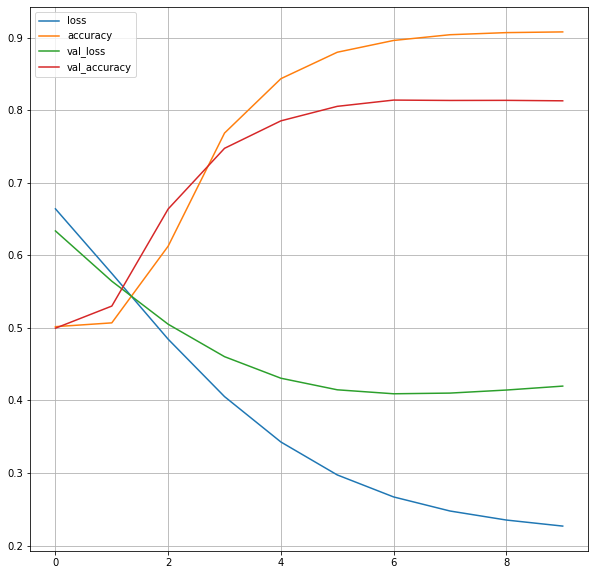

In [27]:
reset_weights(model)
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=5000,
                    validation_split=0.2,
                    verbose=1)
pd.DataFrame(history.history).plot(figsize=(10,10))
plt.grid(True)
plt.show
model.evaluate(X_test, y_test, verbose=2)

Epoch 1/10
32/32 [==============================] - 2s 74ms/step - loss: 0.4263 - accuracy: 0.7639 - val_loss: 0.4085 - val_accuracy: 0.8120
Epoch 2/10
32/32 [==============================] - 2s 73ms/step - loss: 0.2321 - accuracy: 0.9039 - val_loss: 0.4302 - val_accuracy: 0.8116
Epoch 3/10
32/32 [==============================] - 2s 73ms/step - loss: 0.2140 - accuracy: 0.9083 - val_loss: 0.4496 - val_accuracy: 0.8094
Epoch 4/10
32/32 [==============================] - 2s 74ms/step - loss: 0.2060 - accuracy: 0.9107 - val_loss: 0.4664 - val_accuracy: 0.8055
Epoch 5/10
32/32 [==============================] - 2s 74ms/step - loss: 0.1998 - accuracy: 0.9127 - val_loss: 0.4802 - val_accuracy: 0.8031
Epoch 6/10
32/32 [==============================] - 2s 73ms/step - loss: 0.1946 - accuracy: 0.9139 - val_loss: 0.4947 - val_accuracy: 0.8025
Epoch 7/10
32/32 [==============================] - 2s 74ms/step - loss: 0.1902 - accuracy: 0.9162 - val_loss: 0.5088 - val_accuracy: 0.7987
Epoch 8/10
32

[1.13275945186615, 0.6912999749183655]

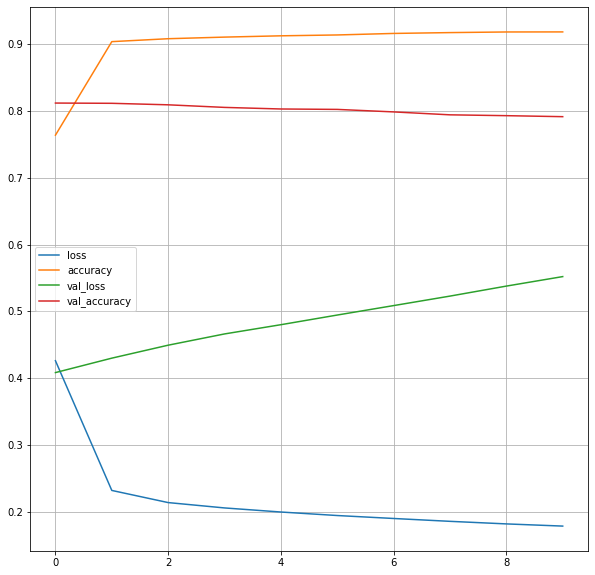

In [28]:
reset_weights(model)
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=1000,
                    validation_split=0.2,
                    verbose=1)
pd.DataFrame(history.history).plot(figsize=(10,10))
plt.grid(True)
plt.show
model.evaluate(X_test, y_test, verbose=2)

Epoch 1/10
64/64 [==============================] - 5s 72ms/step - loss: 0.3591 - accuracy: 0.8436 - val_loss: 0.4571 - val_accuracy: 0.7937
Epoch 2/10
64/64 [==============================] - 5s 72ms/step - loss: 0.2059 - accuracy: 0.9100 - val_loss: 0.5086 - val_accuracy: 0.7890
Epoch 3/10
64/64 [==============================] - 5s 72ms/step - loss: 0.1931 - accuracy: 0.9134 - val_loss: 0.5434 - val_accuracy: 0.7847
Epoch 4/10
64/64 [==============================] - 5s 72ms/step - loss: 0.1850 - accuracy: 0.9159 - val_loss: 0.5755 - val_accuracy: 0.7825
Epoch 5/10
64/64 [==============================] - 5s 72ms/step - loss: 0.1786 - accuracy: 0.9175 - val_loss: 0.6031 - val_accuracy: 0.7763
Epoch 6/10
64/64 [==============================] - 5s 72ms/step - loss: 0.1733 - accuracy: 0.9187 - val_loss: 0.6330 - val_accuracy: 0.7738
Epoch 7/10
64/64 [==============================] - 5s 72ms/step - loss: 0.1686 - accuracy: 0.9206 - val_loss: 0.6598 - val_accuracy: 0.7704
Epoch 8/10
64

[1.4421732425689697, 0.6851000189781189]

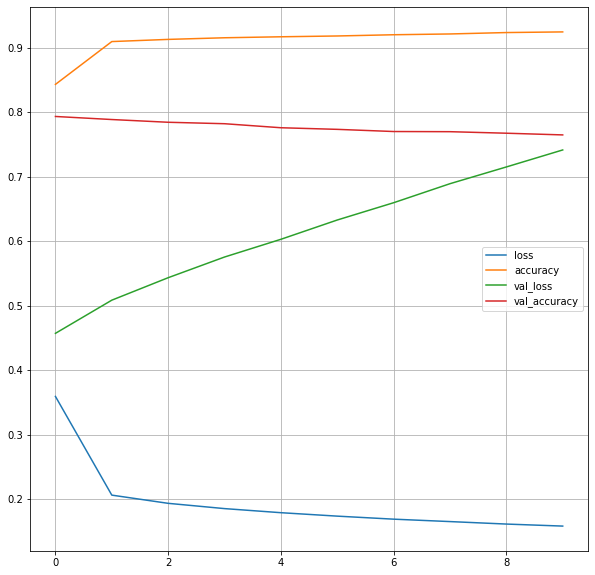

In [29]:
reset_weights(model)
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=500,
                    validation_split=0.2,
                    verbose=1)
pd.DataFrame(history.history).plot(figsize=(10,10))
plt.grid(True)
plt.show
model.evaluate(X_test, y_test, verbose=2)

In [32]:
reset_weights(model)
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=500,
                    validation_split=0.2,
                    verbose=1)
pd.DataFrame(history.history).plot(figsize=(10,10))
plt.grid(True)
plt.show
model.evaluate(X_test, y_test, verbose=2)

Epoch 1/100
64/64 [==============================] - 5s 81ms/step - loss: 0.3328 - accuracy: 0.8217 - val_loss: 0.6490 - val_accuracy: 0.7390
Epoch 2/100
64/64 [==============================] - 5s 81ms/step - loss: 0.1835 - accuracy: 0.9179 - val_loss: 0.7297 - val_accuracy: 0.7398
Epoch 3/100
64/64 [==============================] - 5s 80ms/step - loss: 0.1663 - accuracy: 0.9216 - val_loss: 0.7815 - val_accuracy: 0.7401
Epoch 4/100
64/64 [==============================] - 5s 80ms/step - loss: 0.1553 - accuracy: 0.9251 - val_loss: 0.8369 - val_accuracy: 0.7394
Epoch 5/100
64/64 [==============================] - 5s 80ms/step - loss: 0.1476 - accuracy: 0.9272 - val_loss: 0.8908 - val_accuracy: 0.7384
Epoch 6/100
64/64 [==============================] - 5s 81ms/step - loss: 0.1419 - accuracy: 0.9288 - val_loss: 0.9410 - val_accuracy: 0.7389
Epoch 7/100
64/64 [==============================] - 5s 81ms/step - loss: 0.1378 - accuracy: 0.9301 - val_loss: 0.9872 - val_accuracy: 0.7381
Epoch 

KeyboardInterrupt: ignored

Epoch 1/10
160/160 [==============================] - 12s 72ms/step - loss: 0.2380 - accuracy: 0.8852 - val_loss: 0.6405 - val_accuracy: 0.7634
Epoch 2/10
160/160 [==============================] - 11s 71ms/step - loss: 0.1790 - accuracy: 0.9149 - val_loss: 0.7165 - val_accuracy: 0.7602
Epoch 3/10
160/160 [==============================] - 11s 71ms/step - loss: 0.1696 - accuracy: 0.9173 - val_loss: 0.7783 - val_accuracy: 0.7581
Epoch 4/10
160/160 [==============================] - 11s 72ms/step - loss: 0.1632 - accuracy: 0.9194 - val_loss: 0.8318 - val_accuracy: 0.7563
Epoch 5/10
160/160 [==============================] - 11s 71ms/step - loss: 0.1573 - accuracy: 0.9214 - val_loss: 0.8696 - val_accuracy: 0.7570
Epoch 6/10
160/160 [==============================] - 11s 71ms/step - loss: 0.1530 - accuracy: 0.9237 - val_loss: 0.9253 - val_accuracy: 0.7500
Epoch 7/10
160/160 [==============================] - 11s 71ms/step - loss: 0.1488 - accuracy: 0.9243 - val_loss: 0.9756 - val_accuracy:

[1.8963109254837036, 0.6771000027656555]

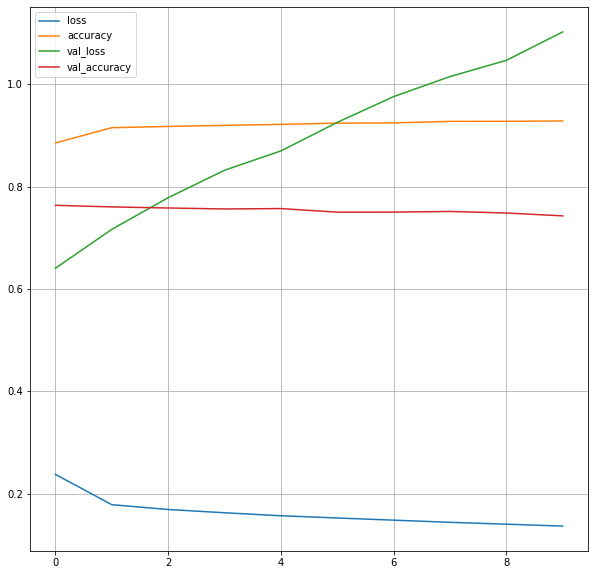

In [30]:
reset_weights(model)
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=200,
                    validation_split=0.2,
                    verbose=1)
pd.DataFrame(history.history).plot(figsize=(10,10))
plt.grid(True)
plt.show
model.evaluate(X_test, y_test, verbose=2)

In [31]:
reset_weights(model)
history = model.fit(X_train, y_train,
                    epochs=10,
                    validation_split=0.2,
                    verbose=1)
pd.DataFrame(history.history).plot(figsize=(10,10))
plt.grid(True)
plt.show
model.evaluate(X_test, y_test, verbose=2)

Epoch 1/10
1000/1000 [==============================] - 70s 70ms/step - loss: 0.2129 - accuracy: 0.8928 - val_loss: 0.8203 - val_accuracy: 0.7354
Epoch 2/10
 410/1000 [===========>..................] - ETA: 41s - loss: 0.1610 - accuracy: 0.9173

KeyboardInterrupt: ignored

## Evaluate the model

In [33]:
results = model.evaluate(test_data.batch(1), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

250/250 - 1s - loss: 1.5747 - accuracy: 0.7249
loss: 1.575
accuracy: 0.725
